# One-dimensional energy balance model

In this notebook, I provide some background on the implementation of the one-dimensional energy balance model, which is based on the MATLAB/Octave code
of the solar heating and zero-dimensional energy balance models as well as the numerical solution to the one-dimensional advection problem. For a detailed description of the exercise, see the PDF document [e05_ebm_1d_basic.pdf](https://seafile.zfn.uni-bremen.de/f/4b1f2e04d6e34f70adb9/).

## M-file script `ebm_1d.m`

First, I go through the M-file script or "main program" `ebm_1d.m`. In contrast to the  models that we ave used until now, in the first section of the code the name of the experiment to be carried out (empty by default) and the names of the input and output files are set:

In [18]:
% Set experiment name
experimentName = '';

% Set input file names
gridsFilename       = 'grids.txt';
swradiationFilename = 'shortwave_radiation.txt';
diffusivityFilename = 'diffusivity.txt';

% Set output file names
historyFilename   = ['history' experimentName '.txt'];
snapshotFilename1 = ['snapshot_yc' experimentName '.txt'];
snapshotFilename2 = ['snapshot_yg' experimentName '.txt'];

This is because the description of the model grid, the insolation and planetary albedo and the diffusivity coefficient are read from input files. This is convenient as it allows for a more compact code. Furthermore, the names of the output files are set: for the "history" file, in which the time series of the simulated global-mean temperature is saved, and for two "snapshot" files, which contain the final results for variables defined at the grid-cell centers (on the `yC` grid) and variables at the grid-cell interfaces (on the `yG` grid).

In the next section of the code, constants and parameters are set. Many are already known from the solar heating and zero-dimensional energy balance models, but there are also a couple of new ones, such as the `solarFraction` that allows to modify the insolation by a constant factor (set to 1.0 by default), the `mixedLayerDepth` that enters the `effectiveHeatCapacity` and the `longwaveCoefficientA` and `longwaveCoefficientB` for the linear parameterization of the outgoing longwave radiation:

In [19]:
% Set named constants
SECONDS_PER_DAY = 86400.0;
DAYS_PER_YEAR   =   365.0;
    
% Set physical constants
pureWaterDensity       = 1.0E03;    % density of pure water at 0 degC
                                    % /(kg m-3)
pureWaterSpecificHeat  = 4218.0;    % specific heat of liquid water at
                                    % 0 degC/(J kg-1 K-1)
pureWaterFreezingPoint = 273.15;    % pure water freezing point/K

% Set run parameters
deltaT     =  5.0*86400.0;          % time step/s
startTime  =  0.0;                  % time to start integration/s
endTime    = 50.0*365.0*86400.0;    % time to stop integration/s
nTimeSteps = round((endTime - startTime)/deltaT); % total number of time
                                                  % steps
% Set model parameters
solarFraction         =  1.0;       % current fraction of solar constant
mixedLayerDepth       = 70.0;       % ocean mixed-layer depth/m
effectiveHeatCapacity = ...
    pureWaterSpecificHeat*pureWaterDensity*mixedLayerDepth; 
                                    % effective heat capacity of the 
                                    % atmosphere-ocean system/(J m-2 K-1)

% Set terms in parameterization of outgoing longwave radiation                                    
longwaveCoefficientA = 205.0;       % constant term (control)
% longwaveCoefficientA = 201.0;       % constant term (2xCO2)
% longwaveCoefficientA = 197.0;       % constant term (4xCO2)
% longwaveCoefficientA = 193.0;       % constant term (6xCO2)
longwaveCoefficientB =   2.23;      % constant factor
                                    % (efficiency of longwave radiative cooling)

Then the grid description is read from the specified file and, as in the one-dimentional advection problem, grid-cell face areas `yA` (in units of m<sup>2</sup>) and volumes (in units of m<sup>3</sup>) are calculated:

In [3]:
% Read grid descriptors from text file (line-by-line using 'fscanf')
gridsFileID = fopen(gridsFilename, 'r');
Ny  = fscanf(gridsFileID, '%d', 1   ); % number of grid cells
dxG = fscanf(gridsFileID, '%f', Ny+1); % lengths between cell faces in X
dyC = fscanf(gridsFileID, '%f', Ny  ); % lengths between cell centers in Y
yG  = fscanf(gridsFileID, '%f', Ny+1); % latitudes of grid-lines/cell faces
yC  = fscanf(gridsFileID, '%f', Ny  ); % latitudes of grid cell centers
rA  = fscanf(gridsFileID, '%f', Ny  ); % vertical face areas
fclose(gridsFileID);

% Calculate face areas normal to X direction
yA = zeros(Ny+1, 1);
for j=1:Ny+1
    yA(j) = mixedLayerDepth*dxG(j);
end

% Calculate grid-cell volumes
volume = zeros(Ny, 1);
for j=1:Ny
    volume(j) = mixedLayerDepth*rA(j);
end

Now the other fields are read from the input files and assigned to one-dimensional arrays or vectors `insolation`, `icefreePlanetaryAlbedo` and `diffKh`. Furthermore, the initial temperature distribution (which is given the generic name `initialTracer`) is set to the currently observed global mean temperature (15 °C) in units of Kelvin:

In [4]:
% Read insolation and ice-free planetary albedo from file
data = load(swradiationFilename);
insolation             = data(:, 2);
icefreePlanetaryAlbedo = data(:, 3);

% Read diffusivity from file
data = load(diffusivityFilename);
diffKh                 = data(:, 2);
% diffKh = zeros(Ny + 1, 1);

% Set initial conditions
initialTracer          = (pureWaterFreezingPoint + 15.0)*ones(Ny, 1);

For easy access in the M-file function `run_model.m` that acually carries out the numerical integration, all parameters and variables are stored in structure variables:

In [5]:
Constants.SECONDS_PER_DAY              = SECONDS_PER_DAY;
Constants.DAYS_PER_YEAR                = DAYS_PER_YEAR;
Constants.pureWaterSpecificHeat        = pureWaterSpecificHeat;
Constants.pureWaterDensity             = pureWaterDensity;
Constants.pureWaterFreezingPoint       = pureWaterFreezingPoint;
Sizes.Ny                               = Ny;
Grids.yC                               = yC;
Grids.yG                               = yG;
Grids.dyC                              = dyC;
Grids.yA                               = yA;   
Grids.volume                           = volume;
RunParameters.deltaT                   = deltaT;
RunParameters.startTime                = startTime;
RunParameters.nTimeSteps               = nTimeSteps;
RunParameters.historyFilename          = historyFilename;
RunParameters.snapshotFilename1        = snapshotFilename1;
RunParameters.snapshotFilename2        = snapshotFilename2;
ModelParameters.solarFraction          = solarFraction;
ModelParameters.insolation             = insolation;
ModelParameters.icefreePlanetaryAlbedo = icefreePlanetaryAlbedo;
ModelParameters.longwaveCoefficientA   = longwaveCoefficientA;
ModelParameters.longwaveCoefficientB   = longwaveCoefficientB;
ModelParameters.effectiveHeatCapacity  = effectiveHeatCapacity;
ModelParameters.diffKh                 = diffKh;      
ModelParameters.initialTracer          = initialTracer;

In MATLAB or GNU Octave, now that all variables are defined and initialized, we can call the M-file function `run_model.m`, which in turn calls an M-file function `calculate_global_average.m`. In a Jupyter noetebook, however, we also need to execute it once in order to save it to an internal M-file. As in the one-dimensional advection problem, I provide the necessary code (after deleting some comments to save space) in the following cell and comment on it afterwards.

## Code of M-file function `calculate_global_average.m`

In [8]:
%%file calculate_global_average.m

function globalAverageTracer = calculate_global_average(volume, tracer)
% CALCULATE_GLOBAL_AVERAGE Calculate global average tracer concentration

% Determine array size
Ny = size(volume);

% Compute volume-weighted global average
sumOfWeights = 0.0;
weightedSum  = 0.0;
for j=1:Ny
    sumOfWeights = sumOfWeights + volume(j);
    weightedSum  = weightedSum  + volume(j)*tracer(j);
end
globalAverageTracer = weightedSum/sumOfWeights;

Created file '/Users/andre/Development/ebm-1d-octave/calculate_global_average.m'.


## Code of M-file function `run_model.m`

In [9]:
%%file run_model.m

function tracer = run_model(Constants, Sizes, Grids, ...
                            RunParameters, ModelParameters)
% RUN_MODEL Direct model integration.

% Retrieve constants and parameters from structure array 'Model'
SECONDS_PER_DAY        = Constants.SECONDS_PER_DAY;
DAYS_PER_YEAR          = Constants.DAYS_PER_YEAR;
pureWaterSpecificHeat  = Constants.pureWaterSpecificHeat;
pureWaterDensity       = Constants.pureWaterDensity;
pureWaterFreezingPoint = Constants.pureWaterFreezingPoint;
Ny                     = Sizes.Ny;
yC                     = Grids.yC;
yG                     = Grids.yG;
dyC                    = Grids.dyC;   
yA                     = Grids.yA;   
volume                 = Grids.volume;
deltaT                 = RunParameters.deltaT;
startTime              = RunParameters.startTime;
nTimeSteps             = RunParameters.nTimeSteps;
historyFilename        = RunParameters.historyFilename;
snapshotFilename1      = RunParameters.snapshotFilename1;
snapshotFilename2      = RunParameters.snapshotFilename2;
solarFraction          = ModelParameters.solarFraction;
insolation             = ModelParameters.insolation;
icefreePlanetaryAlbedo = ModelParameters.icefreePlanetaryAlbedo;
longwaveCoefficientA   = ModelParameters.longwaveCoefficientA;
longwaveCoefficientB   = ModelParameters.longwaveCoefficientB;
effectiveHeatCapacity  = ModelParameters.effectiveHeatCapacity;
diffKh                 = ModelParameters.diffKh;
initialTracer          = ModelParameters.initialTracer;

% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
globalAverageTemperature = calculate_global_average(volume, tracer);
   
% Open history file
historyFileID   = fopen(historyFilename, 'w');

% Write header of history file
fprintf(historyFileID, '%% One-dimensional energy balance model\n');
fprintf(historyFileID, '%% Column 1: Time/a\n');
fprintf(historyFileID, '%% Column 2: Temperature/degC\n');
% Write initial time and global average temperature to history file
fprintf(historyFileID, '%12.4f %12.4f\n', ...
    myTime/(SECONDS_PER_DAY*DAYS_PER_YEAR), ...
    globalAverageTemperature - pureWaterFreezingPoint);

% Preallocate arrays for speed
planetaryAlbedo           = zeros(Ny    , 1);
dfy                       = zeros(Ny + 1, 1); % diffusive flux
                                              % in Y direction
gDiffusion                = zeros(Ny    , 1); % tendency due to diffusion

% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
   
    % Record simulated time
    myTime = myTime + deltaT;
   
    % Calculate diffusive flux in Y direction
    for j=2:Ny
        dfy(j) = -diffKh(j)*yA(j)*(tracer(j) - tracer(j - 1))/dyC(j);
    end

    % Calculate surface temperature tendency due to internal processes
    % (here [explicit] diffusion only)
    for j=1:Ny
        % Take the negative of the divergence of fluxes
        gDiffusion(j) = (dfy(j) - dfy(j + 1))/volume(j);
    end
    
    % Set/calculate planetary albedo
    for j=1:Ny
        planetaryAlbedo(j) = icefreePlanetaryAlbedo(j);
    end
    
    % Calculate net shortwave radiation budget
    % (use the ".*" operator for element-wise multiplication)
    absorbedSolarRadiation = solarFraction*insolation.* ...
        (1.0 - icefreePlanetaryAlbedo);
    
    % Calculate net longwave radiation budget
    outgoingLongwaveRadiation = longwaveCoefficientA + ...
        longwaveCoefficientB*(tracer - pureWaterFreezingPoint);

    % Calculate surface temperature tendency due to external forcing
    gForcing = (absorbedSolarRadiation - outgoingLongwaveRadiation)/ ...
        effectiveHeatCapacity;

    % Calculate total surface temperature tendency
    gTracer = gDiffusion + gForcing;

    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" method)
    tracer  = tracer + deltaT*gTracer;
      
    % Write current time and global average temperature to history file
    globalAverageTemperature = calculate_global_average(volume, tracer);
    fprintf(historyFileID, '%12.4f %12.4f\n', ...
        myTime/(SECONDS_PER_DAY*DAYS_PER_YEAR), ...
        globalAverageTemperature - pureWaterFreezingPoint);
end

% Close history file
fclose(historyFileID);

% Open snapshot files
snapshotFileID1 = fopen(snapshotFilename1, 'w');
snapshotFileID2 = fopen(snapshotFilename2, 'w');

% Write header of snapshot file no. 1 (data at grid-cell centers)
fprintf(snapshotFileID1, '%% Filename: snapshot_yc.txt\n');
fprintf(snapshotFileID1, '%% No. of header lines: 10\n');
fprintf(snapshotFileID1, '%% No. of columns:       7\n');
fprintf(snapshotFileID1, '%% Column  1: yC                        = latitude at grid-cell centers/degN\n');
fprintf(snapshotFileID1, '%% Column  2: insolation                = incoming solar radiation/(W m-2)\n');
fprintf(snapshotFileID1, '%% Column  3: planetaryAlbedo           = planetary albedo\n');
fprintf(snapshotFileID1, '%% Column  4: absorbedSolarRadiation    = net shortwave radiation absorbed by planet/(W m-2)\n');
fprintf(snapshotFileID1, '%% Column  5: outgoingLongwaveRadiation = net longwave radiation emitted by planet/(W m-2))\n');
fprintf(snapshotFileID1, '%% Column  6: gDiffusion                = divergence of diffusive meridional energy transport/(W m-2)\n');
fprintf(snapshotFileID1, '%% Column  7: temperature               = surface temperature/degC\n');
% Write to snapshot file no. 1
for j=1:Ny
    fprintf(snapshotFileID1, '%12.4f%20.6E%20.6E%20.6E%20.6E%20.6E%20.6E\n', ...
        yC(j), ...
        insolation(j), ...
        planetaryAlbedo(j), ...
        absorbedSolarRadiation(j), ...
        outgoingLongwaveRadiation(j), ...
        effectiveHeatCapacity*gDiffusion(j), ...
        tracer(j) - pureWaterFreezingPoint);
end

% Write header of snapshot file no. 2 (data at grid-cell boundaries)
fprintf(snapshotFileID2, '%% Filename: snapshot_yg.txt\n');
fprintf(snapshotFileID2, '%% No. of header lines:  6\n');
fprintf(snapshotFileID2, '%% No. of columns:       3\n');
fprintf(snapshotFileID2, '%% Column  1: yG     = latitude at grid-cell boundaries/degN\n');
fprintf(snapshotFileID2, '%% Column  2: diffKh = diffusivity/(m s-2)\n');
fprintf(snapshotFileID2, '%% Column  3: dfy    = meridional energy transport/W\n');
% Write to snapshot file no. 2
for j=1:Ny+1
    fprintf(snapshotFileID2, '%12.4f%20.6E%20.6E\n', ...
        yG(j), ...
        diffKh(j), ...
        pureWaterSpecificHeat*pureWaterDensity*dfy(j));
end

% Close snapshot files
fclose(snapshotFileID1);
fclose(snapshotFileID2);

Created file '/Users/andre/Development/ebm-1d-octave/run_model.m'.


## Call to M-file function `run_model.m`

In [26]:
run_model(Constants, Sizes, Grids, RunParameters, ModelParameters);

## Plotting of simulated and observed temperature distributions

With the following code, we can read the simulated surface temperature from the output file `snapshot_yc.txt` and the observed temperature of the NCEP reanalysis from a second file and plot them together for comparison:

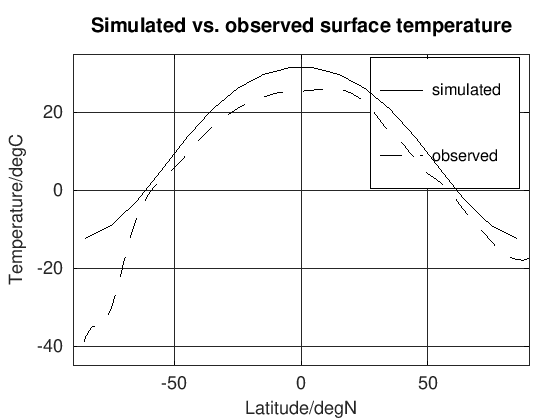

In [27]:
% Set input filnenames
inputFilename = 'snapshot_yc.txt';

% Read model output from multi-column text file
data               = load(inputFilename);
yC                 = data(:, 1); % grid cell center latitude/degN
surfaceTemperature = data(:, 7); % surface temperature/degC


% Read data from two-column text file
data      = load('NCEP_air_zonal_ann.txt');
yObserved = data(:, 1); % grid cell latitude/degN
tObserved = data(:, 2); % annual-mean surface temperature/degC

% Plot simulated and observed temperature data
figure
plot(yC, surfaceTemperature, 'k-', yObserved, tObserved, 'k--', ...
     'LineWidth', 2);
grid on
axis([-90 90 -45 35])
set(gca, 'FontSize', 18)
xlabel('Latitude/degN', 'FontSize', 18)
ylabel('Temperature/degC', 'FontSize', 18)
legend('simulated', 'observed')
title('Simulated vs. observed surface temperature', 'FontSize', 20)

Note that in the archive `ebm_1d_basic.zip`, this code is contained in the M-file script `plot_model_observations.m`.

## Explaining and completing the M-file function `run_model.m`

Now I comment on the code of the M-file function `run_model.m` in detail. In passing, I also give hints how to complete the MATLAB/Octave code in the M-file `run_model_template.m` that is distributed with the archive ebm_1d_basic.zip (see also the PDF document [e05_ebm_1d_basic.pdf](https://seafile.zfn.uni-bremen.de/f/13728a804c9d4dde9178/)).

The first line of the M-file function `run_model.m` is continued to the second and defines the name of the function `run_model` as well as five input arguments and one output argument:

```OCTAVE
function tracer = run_model(Constants, Sizes, Grids, ... 
                            RunParameters, ModelParameters)
```

The input arguments are the five structure arrays (structures for short) `Constants`, `Sizes`, `Grids`, `RunParameters` and `ModelParameters`. The one output parameter is the final surface temperature distribution, which is stored in the variable `tracer`. For convenience and to reduce writing, the input parameters and variables can be retrieved by accessing the fields of the structures using the `.` notation, for example, the number of grid points `Ny`can be retrieved from the `Sizes` structure as follow: `Ny = Sizes.Ny;`.

```OCTAVE
% Retrieve constants and parameters from structure array 'Model'
SECONDS_PER_DAY        = Constants.SECONDS_PER_DAY;
DAYS_PER_YEAR          = Constants.DAYS_PER_YEAR;
pureWaterSpecificHeat  = Constants.pureWaterSpecificHeat;
pureWaterDensity       = Constants.pureWaterDensity;
pureWaterFreezingPoint = Constants.pureWaterFreezingPoint;
Ny                     = Sizes.Ny;
yC                     = Grids.yC;
yG                     = Grids.yG;
dyC                    = Grids.dyC;   
yA                     = Grids.yA;   
volume                 = Grids.volume;
deltaT                 = RunParameters.deltaT;
startTime              = RunParameters.startTime;
nTimeSteps             = RunParameters.nTimeSteps;
historyFilename        = RunParameters.historyFilename;
snapshotFilename1      = RunParameters.snapshotFilename1;
snapshotFilename2      = RunParameters.snapshotFilename2;
solarFraction          = ModelParameters.solarFraction;
insolation             = ModelParameters.insolation;
icefreePlanetaryAlbedo = ModelParameters.icefreePlanetaryAlbedo;
longwaveCoefficientA   = ModelParameters.longwaveCoefficientA;
longwaveCoefficientB   = ModelParameters.longwaveCoefficientB;
effectiveHeatCapacity  = ModelParameters.effectiveHeatCapacity;
diffKh                 = ModelParameters.diffKh;
initialTracer          = ModelParameters.initialTracer;
```

Next the initial conditions are set: the initial time and the initial tracer distribution. In addition, the initial global-mean temperature is calculated by calling the M-file function `calculate_global_average.m`:

```OCTAVE
% Set initial conditions
% Set initial conditions
myTime    = startTime;
tracer    = initialTracer;
globalAverageTemperature = calculate_global_average(volume, tracer);
```

Then the history file is opened and three header lines are written to it:

```OCTAVE
% Open history file
historyFileID   = fopen(historyFilename, 'w');

% Write header of history file
fprintf(historyFileID, '%% One-dimensional energy balance model\n');
fprintf(historyFileID, '%% Column 1: Time/a\n');
fprintf(historyFileID, '%% Column 2: Temperature/degC\n');
% Write initial time and global average temperature to history file
fprintf(historyFileID, '%12.4f %12.4f\n', ...
    myTime/(SECONDS_PER_DAY*DAYS_PER_YEAR), ...
    globalAverageTemperature - pureWaterFreezingPoint);
```

To speed up the time stepping of the numerical solution, auxiliary variables are "pre-allocated", that is, they are defined as arrays of size `Ny + 1` (for the diffusive flux `dfy` at the grid-cell interfaces) and `Ny` (for the planetary Albedo and the tendency due to diffusion `gDiffusion` at the grid-cell centers) and intialized to zero. Otherwise the size of these arrays would grow by one during each iteration of the time loop. This would require the allocation of additional memory in the computer during each iteration, which could slow down the program execution and cause a substantial increase in computing time. 

```OCTAVE
% Preallocate arrays for speed
planetaryAlbedo           = zeros(Ny    , 1);
dfy                       = zeros(Ny + 1, 1); % diffusive flux
                                              % in Y direction
gDiffusion                = zeros(Ny    , 1); % tendency due to diffusion
```

Now follows the core of the model integration in the time loop, which is a `for` loop that is repated `nTimeSteps` times:

```Octave
% Time loop (myIter = iteration counter)
for myIter=1:nTimeSteps
```

The time loop in turn contains `for` loops that run over the spatial dimension. The following `for` loop calculates the diffusive flux `dfy` for each grid-cell interface `j`. Initially, in the M-file `run_model_template`, there are question marks "???" that indicate code lines that still need to be completed: 

```OCTAVE
    % Calculate diffusive flux in Y direction
    for j=2:Ny
        dfy(j) = ???;
    end
```

The diffusive flux `dfy` is equal to the negative product of the diffusion coefficient `diffKh(j)`, the cross-sectional area `yA(j)` and the temperature gradient across the interface, that is, between grid cells `j` and `j - 1`. The temperature gradient is expressed as the temperature difference `tracer(j) - tracer(j - 1)` divided by the distance between the grid-cell centers `dyC(j)`:

```OCTAVE
    % Calculate diffusive flux in Y direction
    for j=2:Ny
        dfy(j) = -diffKh(j)*yA(j)*(tracer(j) - tracer(j - 1))/dyC(j);
    end
```

The tracer tendency due to internal processes is then equal to the divergence of the diffusive flux, that is, the difference between the diffusive flux to the right (north) `dfy(j)` minus the diffusive flux from the left (south) `afy(j + 1)`, divided by the volume of the grid cell `volume(j)`. Hence we need to replace the question marks "???" in the next `for` loop:

```OCTAVE
    % Calculate surface temperature tendency due to internal processes
    % (here [explicit] diffusion only)
    for j=1:Ny
        % Take the negative of the divergence of fluxes
        gDiffusion(j) = ???;
    end
```

as follows:

```OCTAVE
    % Calculate surface temperature tendency due to internal processes
    % (here [explicit] diffusion only)
    for j=1:Ny
        % Take the negative of the divergence of fluxes
        gDiffusion(j) = (dfy(j) - dfy(j + 1))/volume(j);
    end
```

In the following, external sources and sinks of heat are calculated. In this "basic" version of the energy balance model, planetary albedo is simpy set to the ice-free planetary albedo:

```OCTAVE
    % Set/calculate planetary albedo
    for j=1:Ny
        planetaryAlbedo(j) = icefreePlanetaryAlbedo(j);
    end
```

Then net shortwave radiation budget is calculated as the fraction of the solar constant times the insolation at the op of the atmosphere times the fraction that is absorbed by the atmosphere-ocean system, which is given by one minus the ice-free planetary albedo:

```OCTAVE
    % Calculate net shortwave radiation budget
    % (use the ".*" operator for element-wise multiplication)
    absorbedSolarRadiation = solarFraction*insolation.* ...
        (1.0 - icefreePlanetaryAlbedo);
```

Note that in this and the following statements we avoid the use of `for` loops for computational efficiency and instead take advantage of the MATLAB/Octave element-wise addition and multiplication of matrices (which in our case are one-dimensional arrays or vectors). The net shortwave radiation budget can be calculated from the linear parameterization $F_{\infty}^{\uparrow}(x, T_{{\rm s}})=A+B\,T_{{\rm s}}$ as follows: 

```OCTAVE
    % Calculate net longwave radiation budget
    outgoingLongwaveRadiation = longwaveCoefficientA + ...
        longwaveCoefficientB*(tracer - pureWaterFreezingPoint);
```

Given the net shortwave and longwave radiation budgets, we can now calculate the tracer tendency due to external forcing, by taking the difference and dividing by the effective heat capacity:

```OCTAVE
    % Calculate surface temperature tendency due to external
    % forcing
    gForcing = (absorbedSolarRadiation -         
                outgoingLongwaveRadiation)/ ...
               effectiveHeatCapacity;
```

Then we can add the tendencies from the divergence of the diffusive flux and the external forcing to obtain the total surface temperature tendency:

```OCTAVE
    % Calculate total surface temperature tendency
    gTracer = gDiffusion + gForcing;
```

The surface temperature at the future time level (n + 1) can be calculated from the surface temperature at the present time level (n) plus the time step times the total tendency. Hence we replace the remaining question marks "???":

```OCTAVE
    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" method)
    tracer  = ???;
```

by:

```OCTAVE
    % Step surface tracer forward in time 
    % (by "Euler forward" or "forward-in-time" method)
    tracer  = tracer + deltaT*gTracer;
```

Just before the end of the time loop, the current global-mean temperature is first calculated by calling the M-file function `calculate_global_average.m` and then written to the history file:

```OCTAVE
    % Write current time and global average temperature to history file
    globalAverageTemperature = calculate_global_average(volume, tracer);
    fprintf(historyFileID, '%12.4f %12.4f\n', ...
        myTime/(SECONDS_PER_DAY*DAYS_PER_YEAR), ...
        globalAverageTemperature - pureWaterFreezingPoint);
```

This completes the time loop:

```OCTAVE
end % end of time loop
```

The final section of the M-file function `run_model.m` deals with two "snapshot" files: The first one contains the final results for variables defined at the grid-cell centers, the second one contains the final results for variables at the grid-cell boundaries. For both files, a header is written that describes the variables and their units:

```OCTAVE
% Open snapshot files
snapshotFileID1 = fopen(snapshotFilename1, 'w');
snapshotFileID2 = fopen(snapshotFilename2, 'w');

% Write header of snapshot file no. 1 (data at grid-cell centers)
fprintf(snapshotFileID1, '%% Filename: snapshot_yc.txt\n');
fprintf(snapshotFileID1, '%% No. of header lines: 10\n');
fprintf(snapshotFileID1, '%% No. of columns:       7\n');
fprintf(snapshotFileID1, '%% Column  1: yC                        = latitude at grid-cell centers/degN\n');
fprintf(snapshotFileID1, '%% Column  2: insolation                = incoming solar radiation/(W m-2)\n');
fprintf(snapshotFileID1, '%% Column  3: planetaryAlbedo           = planetary albedo\n');
fprintf(snapshotFileID1, '%% Column  4: absorbedSolarRadiation    = net shortwave radiation absorbed by planet/(W m-2)\n');
fprintf(snapshotFileID1, '%% Column  5: outgoingLongwaveRadiation = net longwave radiation emitted by planet/(W m-2))\n');
fprintf(snapshotFileID1, '%% Column  6: gDiffusion                = divergence of diffusive meridional energy transport/(W m-2)\n');
fprintf(snapshotFileID1, '%% Column  7: temperature               = surface temperature/degC\n');
% Write to snapshot file no. 1
for j=1:Ny
    fprintf(snapshotFileID1, '%12.4f%20.6E%20.6E%20.6E%20.6E%20.6E%20.6E\n', ...
        yC(j), ...
        insolation(j), ...
        planetaryAlbedo(j), ...
        absorbedSolarRadiation(j), ...
        outgoingLongwaveRadiation(j), ...
        effectiveHeatCapacity*gDiffusion(j), ...
        tracer(j) - pureWaterFreezingPoint);
end

% Write header of snapshot file no. 2 (data at grid-cell boundaries)
fprintf(snapshotFileID2, '%% Filename: snapshot_yg.txt\n');
fprintf(snapshotFileID2, '%% No. of header lines:  6\n');
fprintf(snapshotFileID2, '%% No. of columns:       3\n');
fprintf(snapshotFileID2, '%% Column  1: yG     = latitude at grid-cell boundaries/degN\n');
fprintf(snapshotFileID2, '%% Column  2: diffKh = diffusivity/(m s-2)\n');
fprintf(snapshotFileID2, '%% Column  3: dfy    = meridional energy transport/W\n');
% Write to snapshot file no. 2
for j=1:Ny+1
    fprintf(snapshotFileID2, '%12.4f%20.6E%20.6E\n', ...
        yG(j), ...
        diffKh(j), ...
        pureWaterSpecificHeat*pureWaterDensity*dfy(j));
end

% Close snapshot files
fclose(snapshotFileID1);
fclose(snapshotFileID2);
```

## Sensitivity experiments

1. For determining the influence of the meridional energy transport, we can either multiply the diffusivity by a constant factor, for example, by 1.5:

```OCTAVE
% Read diffusivity from file
data = load(diffusivityFilename);
diffKh                 = 1.5*data(:, 2);
```

or we can set it to zero:

```OCTAVE
% Read diffusivity from file
data = load(diffusivityFilename);
% diffKh                 = data(:, 2);
diffKh = zeros(Ny + 1, 1);
```

2. For determining the influence of the greenhouse effect, we can simply change the constant term in the outgoing longwave radiation, for example, decreasing it by 4 W m<sup>-2</sup> from 205 W m<sup>-2</sup> to 201 W m<sup>-2</sup>, which roughly corresponds to a doubling of the atmospheric CO<sub>-2</sub> concentration:

```OCTAVE
% Set terms in parameterization of outgoing longwave radiation                         
% longwaveCoefficientA = 205.0;       % constant term (control)
longwaveCoefficientA = 201.0;       % constant term (2xCO2)
% longwaveCoefficientA = 197.0;       % constant term (4xCO2)
% longwaveCoefficientA = 193.0;       % constant term (6xCO2)
longwaveCoefficientB =   2.23;      % constant factor
                                    % (efficiency of longwave radiative cooling)
```

After applying these changes, we need to execute the code cell below that contains the M-file script `ebm_1d.m`, or we need to re-run it in GNU Octave.

## Complete code of M-file script `ebm_1d.m`

For changing parameters and carrying out sensitivity experiments, the complete code of M-file script `ebm_1d.m` is given in the following cell:

In [ ]:
% EBM_1D One-dimensional energy balance model.
% Ebm1D is a one-dimensional energy balance model that calculates the
% annual-mean surface temperature as a function of latitude and time. This main
% program (M-file script) first initializes the model and then runs it over a
% specified number of time steps.

% Author:           Andre Paul
% Written:          2011-11-30
% Last updated:     2019-11-14
%
% Execution:        ebm_1d
% Dependencies:     run_model.m
%
% >> ebm_1d

%-------------------------------------------------------------------------------
% Set experiment and file names
%-------------------------------------------------------------------------------

% Set experiment name
experimentName = '';

% Set input file names
gridsFilename       = 'grids.txt';
swradiationFilename = 'shortwave_radiation.txt';
diffusivityFilename = 'diffusivity.txt';

% Set output file names
historyFilename   = ['history' experimentName '.txt'];
snapshotFilename1 = ['snapshot_yc' experimentName '.txt'];
snapshotFilename2 = ['snapshot_yg' experimentName '.txt'];

%-------------------------------------------------------------------------------
% Set constants, parameters and initial conditions
%-------------------------------------------------------------------------------

% Set named constants
SECONDS_PER_DAY = 86400.0;
DAYS_PER_YEAR   =   365.0;
    
% Set physical constants
pureWaterDensity       = 1.0E03;    % density of pure water at 0 degC
                                    % /(kg m-3)
pureWaterSpecificHeat  = 4218.0;    % specific heat of liquid water at
                                    % 0 degC/(J kg-1 K-1)
pureWaterFreezingPoint = 273.15;    % pure water freezing point/K

% Set run parameters
deltaT     =  5.0*86400.0;          % time step/s
startTime  =  0.0;                  % time to start integration/s
endTime    = 50.0*365.0*86400.0;    % time to stop integration/s
nTimeSteps = round((endTime - startTime)/deltaT); % total number of time
                                                  % steps
% Set model parameters
solarFraction         =  1.0;       % current fraction of solar constant
mixedLayerDepth       = 70.0;       % ocean mixed-layer depth/m
effectiveHeatCapacity = ...
    pureWaterSpecificHeat*pureWaterDensity*mixedLayerDepth; 
                                    % effective heat capacity of the 
                                    % atmosphere-ocean system/(J m-2 K-1)

% Set terms in parameterization of outgoing longwave radiation                                    
longwaveCoefficientA = 205.0;       % constant term (control)
% longwaveCoefficientA = 201.0;       % constant term (2xCO2)
% longwaveCoefficientA = 197.0;       % constant term (4xCO2)
% longwaveCoefficientA = 193.0;       % constant term (6xCO2)
longwaveCoefficientB =   2.23;      % constant factor
                                    % (efficiency of longwave radiative cooling)

%-------------------------------------------------------------------------------
% Set up horizontal grid and coordinate system
%-------------------------------------------------------------------------------

% Read grid descriptors from text file (line-by-line using 'fscanf')
gridsFileID = fopen(gridsFilename, 'r');
Ny  = fscanf(gridsFileID, '%d', 1   ); % number of grid cells
dxG = fscanf(gridsFileID, '%f', Ny+1); % lengths between cell faces in X
dyC = fscanf(gridsFileID, '%f', Ny  ); % lengths between cell centers in Y
yG  = fscanf(gridsFileID, '%f', Ny+1); % latitudes of grid-lines/cell faces
yC  = fscanf(gridsFileID, '%f', Ny  ); % latitudes of grid cell centers
rA  = fscanf(gridsFileID, '%f', Ny  ); % vertical face areas
fclose(gridsFileID);

% Calculate face areas normal to X direction
yA = zeros(Ny+1, 1);
for j=1:Ny+1
    yA(j) = mixedLayerDepth*dxG(j);
end

% Calculate grid-cell volumes
volume = zeros(Ny, 1);
for j=1:Ny
    volume(j) = mixedLayerDepth*rA(j);
end

%-------------------------------------------------------------------------------
% Set other fields
%-------------------------------------------------------------------------------

% Read insolation and ice-free planetary albedo from file
data = load(swradiationFilename);
insolation             = data(:, 2);
icefreePlanetaryAlbedo = data(:, 3);

% Read diffusivity from file
data = load(diffusivityFilename);
diffKh                 = data(:, 2);
% diffKh = zeros(Ny + 1, 1);

% Set initial conditions
initialTracer          = (pureWaterFreezingPoint + 15.0)*ones(Ny, 1);

%-------------------------------------------------------------------------------
% Store parameters and variable(s) in structure arrays
%-------------------------------------------------------------------------------

Constants.SECONDS_PER_DAY              = SECONDS_PER_DAY;
Constants.DAYS_PER_YEAR                = DAYS_PER_YEAR;
Constants.pureWaterSpecificHeat        = pureWaterSpecificHeat;
Constants.pureWaterDensity             = pureWaterDensity;
Constants.pureWaterFreezingPoint       = pureWaterFreezingPoint;
Sizes.Ny                               = Ny;
Grids.yC                               = yC;
Grids.yG                               = yG;
Grids.dyC                              = dyC;
Grids.yA                               = yA;   
Grids.volume                           = volume;
RunParameters.deltaT                   = deltaT;
RunParameters.startTime                = startTime;
RunParameters.nTimeSteps               = nTimeSteps;
RunParameters.historyFilename          = historyFilename;
RunParameters.snapshotFilename1        = snapshotFilename1;
RunParameters.snapshotFilename2        = snapshotFilename2;
ModelParameters.solarFraction          = solarFraction;
ModelParameters.insolation             = insolation;
ModelParameters.icefreePlanetaryAlbedo = icefreePlanetaryAlbedo;
ModelParameters.longwaveCoefficientA   = longwaveCoefficientA;
ModelParameters.longwaveCoefficientB   = longwaveCoefficientB;
ModelParameters.effectiveHeatCapacity  = effectiveHeatCapacity;
ModelParameters.diffKh                 = diffKh;      
ModelParameters.initialTracer          = initialTracer;

%-------------------------------------------------------------------------------
% Run model
%-------------------------------------------------------------------------------

run_model(Constants, Sizes, Grids, RunParameters, ModelParameters);
